In [1]:
import requests
from match import Match
from read_match_data import parse_match
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

This notebook grabs historic match data from the free API https://www.football-data.org and prepares some graphs summarizing latest results.

The next cell is an example cell to run an API query. You can see all possible examples at https://www.football-data.org/documentation/quickstart

In [43]:
# headers = { 
#     'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
#     "X-Unfold-Goals": 'true'
#            }
# uri = 'http://api.football-data.org/v4/matches/327125/head2head?limit=50'
# response = requests.get(uri, headers=headers)
# response.json()

The next cells query the API for a specific league and season. You can change these but the licensed token doesn't have many. You can look at "PL" for Premier League, or "CL" for Champions League, or "PD" for La Liga. You can see all league codes here: https://docs.football-data.org/general/v4/lookup_tables.html, but only Tier 1 are available, as described here: https://www.football-data.org/coverage

In [44]:
# See API documentation for options available: https://docs.football-data.org/general/v4/index.html
league = 'PL' 
seasons = ['2020','2021','2022']

headers = { 
    'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
           }

In [45]:
headers = { 
    'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
    "X-Unfold-Goals": 'true'
           }
uri = 'http://api.football-data.org/v4/matches/327125/head2head?limit=50'
response = requests.get(uri, headers=headers)
response.json()

{'filters': {'limit': '50', 'permission': 'TIER_ONE'},
 'resultSet': {'count': 2,
  'competitions': 'PL',
  'first': '2022-08-06',
  'last': '2023-03-18'},
 'aggregates': {'numberOfMatches': 50,
  'totalGoals': 156,
  'homeTeam': {'id': 73,
   'name': 'Tottenham Hotspur FC',
   'wins': 26,
   'draws': 10,
   'losses': 14},
  'awayTeam': {'id': 340,
   'name': 'Southampton FC',
   'wins': 14,
   'draws': 10,
   'losses': 26}},
 'matches': [{'area': {'id': 2072,
    'name': 'England',
    'code': 'ENG',
    'flag': 'https://crests.football-data.org/770.svg'},
   'competition': {'id': 2021,
    'name': 'Premier League',
    'code': 'PL',
    'type': 'LEAGUE',
    'emblem': 'https://crests.football-data.org/PL.png'},
   'season': {'id': 1490,
    'startDate': '2022-08-05',
    'endDate': '2023-05-28',
    'currentMatchday': 38,
    'winner': {'id': 65,
     'name': 'Manchester City FC',
     'shortName': 'Man City',
     'tla': 'MCI',
     'crest': 'https://crests.football-data.org/65.png'

In [46]:
matches_list = []
for season in seasons:
    uri = 'https://api.football-data.org/v4/competitions/{}/matches?season={}'.format(league, season)
    response = requests.get(uri, headers=headers)
    matches_dict = parse_match(response.json()['matches'])
    matches_list.extend(matches_dict)

In [47]:
matches = [ Match(d['league'], 
                  d['season_start'],
                  d['season_end'], 
                  d['date'],
                  d['status'],
                  d['matchday'],
                  d['home_team'],
                  d['home_team_short'],
                  d['home_team_code'],
                  d['away_team'],
                  d['away_team_short'],
                  d['away_team_code'],
                  d['home_team_score'],
                  d['away_team_score'],
                  d['home_team_halfscore'],
                  d['away_team_halfscore'],) for d in matches_list ]

In [48]:
len(matches)

1140

In [49]:
last_matches = matches[-3:]
game = 2

team_a = last_matches[game].home_team
team_a_short = last_matches[game].home_team_short
team_b = last_matches[game].away_team
team_b_short = last_matches[game].away_team_short

previous_matches = []
for match in matches:
    if match.home_team == team_a and match.away_team == team_b:
        previous_matches.append(match)
    elif match.home_team == team_b and match.away_team == team_a:
        previous_matches.append(match)

previous_matches

[Match(Matchday:10, home:Arsenal FC, away:Wolverhampton Wanderers FC,1:2, winner:Wolverhampton Wanderers FC),
 Match(Matchday:22, home:Wolverhampton Wanderers FC, away:Arsenal FC,2:1, winner:Wolverhampton Wanderers FC),
 Match(Matchday:24, home:Wolverhampton Wanderers FC, away:Arsenal FC,0:1, winner:Arsenal FC),
 Match(Matchday:20, home:Arsenal FC, away:Wolverhampton Wanderers FC,2:1, winner:Arsenal FC),
 Match(Matchday:16, home:Wolverhampton Wanderers FC, away:Arsenal FC,0:2, winner:Arsenal FC),
 Match(Matchday:38, home:Arsenal FC, away:Wolverhampton Wanderers FC,5:0, winner:Arsenal FC)]

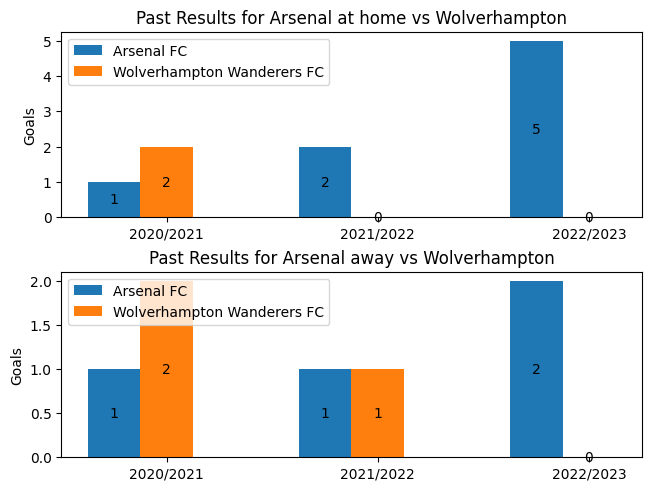

In [50]:
team_a_home_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.home_team==team_a ]
team_a_away_season = [ str(x.season_start.year)+"/"+str(x.season_end.year) for x in previous_matches if x.away_team==team_a ]

team_a_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_a ]
team_b_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_b ]
team_a_away_scores = [ x.away_team_score for x in previous_matches if x.away_team==team_a ]
team_b_home_scores = [ x.home_team_score for x in previous_matches if x.home_team==team_b ]

home_graph = {
    team_a: team_a_home_scores,
    team_b: team_b_home_scores
}
away_graph = {
    team_a: team_a_away_scores,
    team_b: team_b_away_scores
}

fig, (ax1,ax2) = plt.subplots(2,1, layout="constrained")
x = np.arange(len(team_a_home_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in home_graph.items():
    offset = width * multiplier
    graph = ax1.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_home_season)
    ax1.bar_label(graph, label_type='center')
    multiplier += 1

x = np.arange(len(team_a_away_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in away_graph.items():
    offset = width * multiplier
    graph = ax2.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_away_season)
    ax2.bar_label(graph, label_type='center')
    multiplier += 1

ax1.set_title("Past Results for {} at home vs {}".format(team_a_short, team_b_short))
ax1.set_ylabel("Goals")
ax1.legend(loc='upper left')
ax2.set_title("Past Results for {} away vs {}".format(team_a_short, team_b_short))
ax2.set_ylabel("Goals")
ax2.legend(loc='upper left')

plt.show()